# 🧠 OASIS‑1 ViT Pipeline (PyTorch + `timm`)

End‑to‑end notebook for our project:
- Build **patient‑level** index from OASIS‑1 (all downloaded discs)
- Convert (via our script) to **NIfTI** and slice to **2D** PNGs
- Train **Vision Transformer (ViT)** with transfer learning (`timm`)
- Evaluate **slice‑level** and **patient‑level** metrics (AUC, F1, Balanced Accuracy)
- Save best model + recommended threshold

> **Note:** This is an educational research notebook. Not for clinical use.

## 0. Environment
Run this once if your environment misses some packages (comment out if already installed).

In [26]:
# If needed (uncomment as required):
# !pip install -U timm monai nibabel pandas scikit-learn matplotlib tqdm torchmetrics
# !pip install opencv-python-headless  # for cv2 if not present

## 1. Config
Adjust paths if your repo structure differs. Assumes you've downloaded **all 12 discs** under `data/raw/…`.

In [27]:
from pathlib import Path
import os, json, random, math, shutil
import numpy as np
import pandas as pd

# --- Paths ---
RAW_ROOT       = Path("/Users/sofiiahembara/Documents/ai-dementia-mri/ai-dementia-mri/data/raw")
CLINICAL_CSV   = Path("/Users/sofiiahembara/Documents/ai-dementia-mri/ai-dementia-mri/data/raw/mri_alz/oasis_cross-sectional.csv")

NIFTI_DIR      = Path("/Users/sofiiahembara/Documents/ai-dementia-mri/ai-dementia-mri/data/processed/oasis1_nifti")
INDEX_SUBJECTS = Path("/Users/sofiiahembara/Documents/ai-dementia-mri/ai-dementia-mri/data/index_oasis1.csv")
SLICES_DIR     = Path("/Users/sofiiahembara/Documents/ai-dementia-mri/ai-dementia-mri/data/interim/oasis1_2d")
INDEX_SLICES   = Path("/Users/sofiiahembara/Documents/ai-dementia-mri/ai-dementia-mri/data/index_oasis1_2d.csv")

# --- Training / Eval ---
SEED            = 42
IMG_SIZE        = 224
K_SLICES        = 12        # per volume (evenly spaced axial slices)
VAL_FRACTION    = 0.15
TEST_FRACTION   = 0.15

MODEL_NAME      = "vit_tiny"  # one of ["resnet18", "vit_tiny", "vit_small"]
FREEZE_EPOCHS   = 2           # freeze backbone for probe
EPOCHS          = 25
BATCH_SIZE      = 32
LR              = 5e-5        # smaller for ViT
WEIGHT_DECAY    = 1e-2
PATIENCE        = 6
AMP             = True        # mixed precision if CUDA available

ARTIFACTS_DIR   = Path("artifacts"); ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
CKPT_DIR        = Path("checkpoints"); CKPT_DIR.mkdir(parents=True, exist_ok=True)
BEST_WEIGHTS    = CKPT_DIR / "best_vit.pt"
LAST_WEIGHTS    = CKPT_DIR / "last_vit.pt"

import torch
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Device: {DEVICE}")
print("RAW_ROOT exists:", RAW_ROOT.exists())
print("CLINICAL_CSV exists:", CLINICAL_CSV.exists())

Device: cpu
RAW_ROOT exists: True
CLINICAL_CSV exists: True


## 2. Utilities & Reproducibility

In [28]:
import torch, random, numpy as np

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(SEED)

## 3. Build/Update Subject‑Level Index
We use our existing helper script `scripts/oasis1_prepare.py` to scan **all discs**, create **NIfTI** copies, and write a subject‑level index with columns:
- `subject_id`, `path` (NIfTI), `cdr`, `label` (dementia / non_demented), `split` (train/val/test).

If the script isn't present, we fallback to a **lightweight** index builder that reads the clinical CSV and searches for NIfTI/Analyze files in `RAW_ROOT`. 

In [29]:
from subprocess import run, CalledProcessError

def build_subject_index_with_script():
    cmd = [
        "python", "scripts/oasis1_prepare.py",
        "--root", str(RAW_ROOT),
        "--clinical", str(CLINICAL_CSV),
        "--out_nifti", str(NIFTI_DIR),
        "--out_index", str(INDEX_SUBJECTS),
    ]
    print("Running:", " ".join(cmd))
    try:
        res = run(cmd, check=True, capture_output=True, text=True)
        print(res.stdout)
        if res.stderr:
            print(res.stderr)
        return True
    except (FileNotFoundError, CalledProcessError) as e:
        print("Script path missing or error in script; will try fallback builder. Error:", e)
        return False

ok = build_subject_index_with_script()

if not ok:
    # --- Fallback (simple version): read clinical CSV and create minimal index without conversion ---
    print("⚠️ Fallback index builder (no NIfTI conversion). Expect paths to point to existing NIfTI/ANALYZE files.")
    dfc = pd.read_csv(CLINICAL_CSV)
    # Guess subject id column
    cand_cols = [c for c in dfc.columns if "ID" in c.upper() or "SUBJECT" in c.upper()]
    if not cand_cols:
        raise SystemExit("Cannot infer subject id column in clinical CSV. Please adjust fallback code.")
    sid_col = cand_cols[0]
    dfc["subject_id"] = dfc[sid_col].astype(str)

    # Label from CDR: dementia if CDR >= 0.5
    cdr_col = None
    for c in dfc.columns:
        if c.strip().lower() in ["cdr", "cdrsum", "cdr_sum", "cdr_global", "cdr_global_score"]:
            cdr_col = c; break
    if cdr_col is None:
        raise SystemExit("Cannot infer CDR column name. Adjust fallback code.")

    dfc["cdr"] = pd.to_numeric(dfc[cdr_col], errors="coerce").fillna(0.0)
    dfc["label"] = np.where(dfc["cdr"] >= 0.5, "dementia", "non_demented")

    # Find any image file path
    paths = []
    for subj in dfc["subject_id"].unique():
        globbed = list(RAW_ROOT.rglob(f"*{subj}*.*"))
        nii = [p for p in globbed if p.suffix in [".nii", ".gz"]]
        hdr = [p for p in globbed if p.suffix == ".hdr"]
        pick = None
        if nii: pick = nii[0]
        elif hdr: pick = hdr[0]
        else: pick = globbed[0] if globbed else None
        paths.append((subj, str(pick) if pick else ""))

    path_df = pd.DataFrame(paths, columns=["subject_id", "path"])
    merged = dfc.merge(path_df, on="subject_id", how="left")
    merged = merged[["subject_id", "path", "cdr", "label"]].drop_duplicates("subject_id")

    # patient-level split
    from sklearn.model_selection import train_test_split
    train_ids, tmp_ids = train_test_split(
        merged["subject_id"], test_size=VAL_FRACTION + TEST_FRACTION, random_state=SEED, stratify=merged["label"]
    )
    tmp = merged[merged["subject_id"].isin(tmp_ids)]
    val_ids, test_ids = train_test_split(
        tmp["subject_id"], test_size=TEST_FRACTION / (VAL_FRACTION + TEST_FRACTION), random_state=SEED, stratify=tmp["label"]
    )
    def assign_split(sid):
        if sid in set(train_ids): return "train"
        if sid in set(val_ids):   return "val"
        return "test"
    merged["split"] = merged["subject_id"].map(assign_split)
    merged.rename(columns={"path":"nifti_path"}, inplace=True)
    merged.to_csv(INDEX_SUBJECTS, index=False)
    print(f"✅ Fallback index saved: {INDEX_SUBJECTS} (N={len(merged)})")

print(INDEX_SUBJECTS.resolve())
try:
    display(pd.read_csv(INDEX_SUBJECTS).head())
except Exception:
    print(pd.read_csv(INDEX_SUBJECTS).head())

Running: python scripts/oasis1_prepare.py --root /Users/sofiiahembara/Documents/ai-dementia-mri/ai-dementia-mri/data/raw --clinical /Users/sofiiahembara/Documents/ai-dementia-mri/ai-dementia-mri/data/raw/mri_alz/oasis_cross-sectional.csv --out_nifti /Users/sofiiahembara/Documents/ai-dementia-mri/ai-dementia-mri/data/processed/oasis1_nifti --out_index /Users/sofiiahembara/Documents/ai-dementia-mri/ai-dementia-mri/data/index_oasis1.csv
Script path missing or error in script; will try fallback builder. Error: [Errno 2] No such file or directory: 'python'
⚠️ Fallback index builder (no NIfTI conversion). Expect paths to point to existing NIfTI/ANALYZE files.
✅ Fallback index saved: /Users/sofiiahembara/Documents/ai-dementia-mri/ai-dementia-mri/data/index_oasis1.csv (N=436)
/Users/sofiiahembara/Documents/ai-dementia-mri/ai-dementia-mri/data/index_oasis1.csv


,subject_id,nifti_path,cdr,label,split
0,OAS1_0001_MR1,/Users/sofiiahembara/Documents/ai-dementia-mri...,0.0,non_demented,train
1,OAS1_0002_MR1,/Users/sofiiahembara/Documents/ai-dementia-mri...,0.0,non_demented,val
2,OAS1_0003_MR1,/Users/sofiiahembara/Documents/ai-dementia-mri...,0.5,dementia,train
3,OAS1_0004_MR1,/Users/sofiiahembara/Documents/ai-dementia-mri...,0.0,non_demented,train
4,OAS1_0005_MR1,/Users/sofiiahembara/Documents/ai-dementia-mri...,0.0,non_demented,train


## 4. Make 2D Slices & Slice‑Level Index
We generate **K evenly spaced axial slices** per volume and save to PNGs. Then we build a slice‑level index with columns: `path, label, split, subject_id`.

In [30]:
from subprocess import run, CalledProcessError
SLICES_DIR.mkdir(parents=True, exist_ok=True)

def run_make_slices():
    cmd = [
        "python", "scripts/make_2d_slices.py",
        "--index_csv", str(INDEX_SUBJECTS),
        "--out_dir", str(SLICES_DIR),
        "--k", str(K_SLICES),
        "--size", str(IMG_SIZE)
    ]
    print("Running:", " ".join(cmd))
    try:
        res = run(cmd, check=True, capture_output=True, text=True)
        print(res.stdout)
        if res.stderr:
            print(res.stderr)
        return True
    except (FileNotFoundError, CalledProcessError) as e:
        print("make_2d_slices.py missing or errored. Error:", e)
        return False

ok = run_make_slices()

subj_df = pd.read_csv(INDEX_SUBJECTS)[["subject_id","label","split"]]
pngs = list(SLICES_DIR.rglob("*.png"))
rows = []
for p in pngs:
    sid = p.parent.name
    if sid not in set(subj_df["subject_id"]):
        candidates = [s for s in subj_df["subject_id"] if s in p.as_posix()]
        sid = candidates[0] if candidates else None
    if sid is None: 
        continue
    rows.append((str(p), sid))

slice_df = pd.DataFrame(rows, columns=["path", "subject_id"]).merge(subj_df, on="subject_id", how="left")
slice_df = slice_df.dropna(subset=["label","split"])
slice_df.to_csv(INDEX_SLICES, index=False)
print(f"✅ Slice index saved: {INDEX_SLICES} (N={len(slice_df)})")
try:
    display(slice_df.head())
except Exception:
    print(slice_df.head())

Running: python scripts/make_2d_slices.py --index_csv /Users/sofiiahembara/Documents/ai-dementia-mri/ai-dementia-mri/data/index_oasis1.csv --out_dir /Users/sofiiahembara/Documents/ai-dementia-mri/ai-dementia-mri/data/interim/oasis1_2d --k 12 --size 224
make_2d_slices.py missing or errored. Error: [Errno 2] No such file or directory: 'python'
✅ Slice index saved: /Users/sofiiahembara/Documents/ai-dementia-mri/ai-dementia-mri/data/index_oasis1_2d.csv (N=1288)


,path,subject_id,label,split
0,/Users/sofiiahembara/Documents/ai-dementia-mri...,OAS1_0018_MR1,non_demented,train
1,/Users/sofiiahembara/Documents/ai-dementia-mri...,OAS1_0030_MR1,non_demented,train
2,/Users/sofiiahembara/Documents/ai-dementia-mri...,OAS1_0065_MR1,non_demented,val
3,/Users/sofiiahembara/Documents/ai-dementia-mri...,OAS1_0032_MR1,non_demented,train
4,/Users/sofiiahembara/Documents/ai-dementia-mri...,OAS1_0078_MR1,non_demented,val


## 5. Dataset & DataLoaders
Z‑score normalization per slice (grayscale → 3 channels for ViT).

In [41]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch

# Автовизначення колонок у df
IMG_COL = None
for cand in ["slice_path", "png_path", "path", "image_path"]:
    if cand in train_df.columns:
        IMG_COL = cand
        break
if IMG_COL is None:
    raise ValueError(f"Не знайдено колонку зі шляхом до зображення у train_df. Є: {train_df.columns.tolist()}")

SID_COL = "subject_id" if "subject_id" in train_df.columns else ("sid" if "sid" in train_df.columns else None)
if SID_COL is None:
    raise ValueError(f"Не знайдено колонку з patient id (subject_id/sid). Є: {train_df.columns.tolist()}")

def make_tfms(size: int, augment: bool):
    ops = [transforms.Resize((size, size))]
    if augment:
        ops += [
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=10),
        ]
    ops += [
        transforms.ToTensor(),  # (1,H,W) для L
        transforms.Lambda(lambda t: t.expand(3, -1, -1) if t.shape[0] == 1 else t),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ]
    return transforms.Compose(ops)

class SimpleSliceDataset(Dataset):
    def __init__(self, df, size=224, augment=False):
        self.df = df.reset_index(drop=True)
        self.tf = make_tfms(size, augment)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        row = self.df.iloc[i]
        img = Image.open(row[IMG_COL]).convert("L")
        x = self.tf(img)
        y = 1.0 if str(row["label"]).lower() == "dementia" else 0.0
        y = torch.tensor(y, dtype=torch.float32)
        sid = row[SID_COL]
        return x, y, sid

# ---- СУМІСНИЙ «ПЕРЕХІДНИК»: приймає k, split, index_csv тощо і ігнорує їх
class MRISliceDataset(SimpleSliceDataset):
    def __init__(self, df, k=None, size=224, augment=False, split=None, index_csv=None, **kwargs):
        super().__init__(df=df, size=size, augment=augment)

# ---- Створення датасетів (можеш лишити свій існуючий код створення)
train_ds = MRISliceDataset(df=train_df, k=K_SLICES, size=IMG_SIZE, augment=True)
val_ds   = MRISliceDataset(df=val_df,   k=K_SLICES, size=IMG_SIZE, augment=False)
test_ds  = MRISliceDataset(df=test_df,  k=K_SLICES, size=IMG_SIZE, augment=False)

# На macOS краще без воркерів, щоб уникати падінь
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0, pin_memory=(DEVICE=="cuda"))
val_dl   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=(DEVICE=="cuda"))
test_dl  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=(DEVICE=="cuda"))

## 6. Model (ViT / ResNet via `timm`)

In [42]:
import torch.nn as nn
import torch
import timm

def build_model(name="vit_tiny", num_classes=1):
    if name == "resnet18":
        m = timm.create_model("resnet18", pretrained=True, num_classes=num_classes)
    elif name == "vit_tiny":
        m = timm.create_model("vit_tiny_patch16_224", pretrained=True, num_classes=num_classes)
    elif name == "vit_small":
        m = timm.create_model("vit_small_patch16_224", pretrained=True, num_classes=num_classes)
    else:
        raise ValueError("Unknown model: " + name)
    return m

model = build_model(MODEL_NAME, num_classes=1).to(DEVICE)

def freeze_backbone(m: nn.Module, freeze: bool = True):
    head_names = ["head", "classifier", "fc"]
    for n,p in m.named_parameters():
        is_head = any(h in n for h in head_names)
        if not is_head:
            p.requires_grad = not (freeze)

if FREEZE_EPOCHS > 0:
    freeze_backbone(model, True)

n_trainable = sum(p.requires_grad for p in model.parameters())
n_params    = sum(p.numel() for p in model.parameters())
print(f"Parameters: total={n_params:,} | trainable={n_trainable:,}")

Parameters: total=5,524,609 | trainable=50


## 7. Training & Evaluation (slice‑level and patient‑level)

In [43]:
# ==== SAFE TRAINING BLOCK (no multiprocessing) =================================
from pathlib import Path
import os, json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# --- Required globals with sensible defaults (override if already defined) ---
DEVICE         = "cuda" if torch.cuda.is_available() else "cpu"
INDEX_SLICES   = Path("data/index_oasis1_2d.csv") if 'INDEX_SLICES' not in globals() else Path(INDEX_SLICES)
ARTIFACTS_DIR  = Path("artifacts"); ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
CKPT_DIR       = Path("checkpoints"); CKPT_DIR.mkdir(parents=True, exist_ok=True)
BEST_WEIGHTS   = CKPT_DIR / "best_vit.pt" if 'BEST_WEIGHTS' not in globals() else Path(BEST_WEIGHTS)
LAST_WEIGHTS   = CKPT_DIR / "last_vit.pt" if 'LAST_WEIGHTS' not in globals() else Path(LAST_WEIGHTS)

BATCH_SIZE     = 32   if 'BATCH_SIZE' not in globals() else int(BATCH_SIZE)
EPOCHS         = 25   if 'EPOCHS' not in globals() else int(EPOCHS)
FREEZE_EPOCHS  = 2    if 'FREEZE_EPOCHS' not in globals() else int(FREEZE_EPOCHS)
PATIENCE       = 6    if 'PATIENCE' not in globals() else int(PATIENCE)
LR             = 5e-5 if 'LR' not in globals() else float(LR)
WEIGHT_DECAY   = 1e-2 if 'WEIGHT_DECAY' not in globals() else float(WEIGHT_DECAY)
AMP            = True if 'AMP' not in globals() else bool(AMP)

IMG_SIZE       = 224  if 'IMG_SIZE' not in globals() else int(IMG_SIZE)
K_SLICES       = 12   if 'K_SLICES' not in globals() else int(K_SLICES)

# --- Sanity: MRISliceDataset must exist ---
try:
    MRISliceDataset  # noqa: F401
except NameError as _:
    raise RuntimeError("Define or import MRISliceDataset before running this cell.")

# --- Read slice index and make splits (also used for pos_weight) ---
df_slices = pd.read_csv(INDEX_SLICES)
req_cols = {"path", "label", "split", "subject_id"}
missing = req_cols - set(df_slices.columns)
if missing:
    raise ValueError(f"{INDEX_SLICES} must contain columns {req_cols} (missing: {missing})")

train_df = df_slices[df_slices["split"]=="train"].reset_index(drop=True)
val_df   = df_slices[df_slices["split"]=="val"].reset_index(drop=True)
test_df  = df_slices[df_slices["split"]=="test"].reset_index(drop=True)

# --- Datasets (augment тільки на train) ---
try:
    train_ds = MRISliceDataset(df=train_df, k=K_SLICES, size=IMG_SIZE, augment=True)
    val_ds   = MRISliceDataset(df=val_df,   k=K_SLICES, size=IMG_SIZE, augment=False)
    test_ds  = MRISliceDataset(df=test_df,  k=K_SLICES, size=IMG_SIZE, augment=False)
except TypeError:
    # якщо у твоїй реалізації немає іменованого параметра df — передаємо DF позиційно
    train_ds = MRISliceDataset(train_df, k=K_SLICES, size=IMG_SIZE, augment=True)
    val_ds   = MRISliceDataset(val_df,   k=K_SLICES, size=IMG_SIZE, augment=False)
    test_ds  = MRISliceDataset(test_df,  k=K_SLICES, size=IMG_SIZE, augment=False)

# --- DataLoaders: ключова зміна → num_workers=0, щоб уникнути pickle-крашу ---
pin = torch.cuda.is_available()
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0, pin_memory=pin)
val_dl   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=pin)
test_dl  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=pin)

# --- Loss with class imbalance ---
pos_count = (train_df["label"]=="dementia").sum()
neg_count = (train_df["label"]=="non_demented").sum()
pos_weight = torch.tensor(
    [neg_count / max(1, pos_count)],
    device=DEVICE, dtype=torch.float32
)
print("pos_weight:", float(pos_weight.cpu().numpy()[0]))
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# --- Optim / sched / AMP ---
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                              lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=LR*0.1)
scaler    = torch.cuda.amp.GradScaler(enabled=(DEVICE=="cuda" and AMP))

# --- Helper: (un)freeze backbone generично ---
def freeze_backbone(m, freeze=True):
    # заморожуємо все, крім голів (fc/head/classifier)
    head_keys = ("fc", "head", "classifier")
    for name, p in m.named_parameters():
        if any(k in name for k in head_keys):
            p.requires_grad = True
        else:
            p.requires_grad = not (not freeze)

# --- Metrics ---
from sklearn.metrics import roc_auc_score, f1_score, balanced_accuracy_score

def compute_metrics(y_true, y_prob, thr=0.5):
    y_true = np.asarray(y_true).astype(int)
    y_prob = np.asarray(y_prob)
    y_pred = (y_prob >= thr).astype(int)
    out = {}
    try:
        out["roc_auc"] = float(roc_auc_score(y_true, y_prob))
    except Exception:
        out["roc_auc"] = float("nan")
    out["f1"] = float(f1_score(y_true, y_pred))
    out["bal_acc"] = float(balanced_accuracy_score(y_true, y_pred))
    return out

def patient_level_metrics(y_true_slice, y_prob_slice, sids_slice, thr=0.5):
    df = pd.DataFrame(dict(sid=sids_slice, y=y_true_slice.tolist(), p=np.asarray(y_prob_slice).tolist()))
    agg = df.groupby("sid").agg(y=("y","mean"), p=("p","mean"))
    y_true = (agg["y"].values > 0.5).astype(int)
    y_prob = agg["p"].values
    return compute_metrics(y_true, y_prob, thr=thr)

# --- One epoch ---
from tqdm import tqdm

def run_epoch(loader, train=True):
    model.train(train)
    all_y, all_p, all_sid = [], [], []
    total_loss, total_n = 0.0, 0
    for x, y, sid in tqdm(loader, disable=False):
        x = x.to(DEVICE, non_blocking=True)
        y = y.float().view(-1).to(DEVICE, non_blocking=True)

        if train:
            optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda" and AMP)):
            logits = model(x).squeeze(1)
            loss   = loss_fn(logits, y)
            prob   = torch.sigmoid(logits).detach().cpu().numpy()

        if train:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        total_loss += float(loss.item()) * x.size(0)
        total_n    += x.size(0)
        all_y.extend(y.detach().cpu().numpy().tolist())
        all_p.extend(prob.tolist())
        all_sid.extend(list(sid))

    metrics = compute_metrics(all_y, all_p, thr=0.5)
    return total_loss / max(1, total_n), np.array(all_y), np.array(all_p), np.array(all_sid), metrics

# --- Train loop (patient-level early stopping) ---
best_score = -1.0
best_thr   = 0.5
stale      = 0

if FREEZE_EPOCHS > 0:
    print(f"🧊 Freezing backbone for {FREEZE_EPOCHS} epoch(s)")
    freeze_backbone(model, True)

for epoch in range(1, EPOCHS+1):
    if epoch == FREEZE_EPOCHS + 1 and FREEZE_EPOCHS > 0:
        print("🔓 Unfreezing backbone")
        freeze_backbone(model, False)
        for g in optimizer.param_groups:
            g["lr"] = LR

    tr_loss, _, _, _, tr_m = run_epoch(train_dl, train=True)
    with torch.no_grad():
        va_loss, yv, pv, sidv, va_m = run_epoch(val_dl, train=False)

    # підбір порогу по валідації на patient-level (за F1)
    thrs = np.linspace(0.05, 0.95, 19)
    f1s  = [patient_level_metrics(yv, pv, sidv, thr=t)["f1"] for t in thrs]
    cur_thr = float(thrs[int(np.argmax(f1s))])
    va_pat  = patient_level_metrics(yv, pv, sidv, thr=cur_thr)

    print(f"Epoch {epoch:02d} | "
          f"train_loss={tr_loss:.4f} | val_loss={va_loss:.4f} | "
          f"slice: AUC={va_m['roc_auc']:.3f} F1={va_m['f1']:.3f} BA={va_m['bal_acc']:.3f} | "
          f"patient@thr={cur_thr:.2f}: AUC={va_pat['roc_auc']:.3f} F1={va_pat['f1']:.3f} BA={va_pat['bal_acc']:.3f} | "
          f"lr={scheduler.get_last_lr()[0]:.2e}")

    # критерій — patient-level ROC AUC; якщо NaN, то BA
    score = va_pat["roc_auc"]
    if np.isnan(score):
        score = va_pat["bal_acc"]

    torch.save(model.state_dict(), str(LAST_WEIGHTS))

    if score > best_score:
        best_score = score
        best_thr   = cur_thr
        stale      = 0
        torch.save(model.state_dict(), str(BEST_WEIGHTS))
        with open(ARTIFACTS_DIR / "thresholds.json", "w") as f:
            json.dump({"metric":"f1_patient", "thr":best_thr}, f, indent=2)
        print(f"  ↳ ✅ saved best: {BEST_WEIGHTS.name} (score={best_score:.3f}, thr={best_thr:.2f})")
    else:
        stale += 1
        if stale >= PATIENCE:
            print(f"⏹ Early stopping: no improvement for {PATIENCE} epoch(s).")
            break

    scheduler.step()

print(f"Best patient-level score: {best_score:.3f} at thr={best_thr:.2f}")

# --- Optional: final eval on test with best_thr ---
with torch.no_grad():
    te_loss, yt, pt, sidt, te_m = run_epoch(test_dl, train=False)
    te_pat = patient_level_metrics(yt, pt, sidt, thr=best_thr)
print("TEST slice-level:", te_m)
print("TEST patient-level @best_thr:", te_pat)
# ==============================================================================

pos_weight: 1.058823585510254
🧊 Freezing backbone for 2 epoch(s)


100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


Epoch 01 | train_loss=0.6875 | val_loss=0.8023 | slice: AUC=0.835 F1=0.397 BA=0.621 | patient@thr=0.70: AUC=1.000 F1=1.000 BA=1.000 | lr=5.00e-05
  ↳ ✅ saved best: best_vit.pt (score=1.000, thr=0.70)


100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


Epoch 02 | train_loss=0.5673 | val_loss=0.5007 | slice: AUC=0.884 F1=0.600 BA=0.804 | patient@thr=0.55: AUC=1.000 F1=1.000 BA=1.000 | lr=4.98e-05
🔓 Unfreezing backbone


100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


Epoch 03 | train_loss=0.4948 | val_loss=0.6612 | slice: AUC=0.874 F1=0.545 BA=0.786 | patient@thr=0.70: AUC=1.000 F1=1.000 BA=1.000 | lr=4.93e-05


100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


Epoch 04 | train_loss=0.3966 | val_loss=0.4922 | slice: AUC=0.917 F1=0.607 BA=0.830 | patient@thr=0.60: AUC=1.000 F1=1.000 BA=1.000 | lr=4.91e-05


100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


Epoch 05 | train_loss=0.3212 | val_loss=1.0263 | slice: AUC=0.877 F1=0.483 BA=0.732 | patient@thr=0.85: AUC=1.000 F1=1.000 BA=1.000 | lr=4.79e-05


100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


Epoch 06 | train_loss=0.2400 | val_loss=0.7203 | slice: AUC=0.883 F1=0.593 BA=0.821 | patient@thr=0.75: AUC=1.000 F1=1.000 BA=1.000 | lr=4.64e-05


100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Epoch 07 | train_loss=0.1945 | val_loss=1.5800 | slice: AUC=0.813 F1=0.454 BA=0.696 | patient@thr=0.90: AUC=1.000 F1=1.000 BA=1.000 | lr=4.45e-05
⏹ Early stopping: no improvement for 6 epoch(s).
Best patient-level score: 1.000 at thr=0.70


100%|██████████| 6/6 [00:03<00:00,  1.95it/s]

TEST slice-level: {'roc_auc': 0.6891741071428571, 'f1': 0.5769230769230769, 'bal_acc': 0.65625}
TEST patient-level @best_thr: {'roc_auc': 0.75, 'f1': 0.5, 'bal_acc': 0.625}


## 8. Final Evaluation on Test

In [44]:
# load best weights
model.load_state_dict(torch.load(str(BEST_WEIGHTS), map_location=DEVICE))
model.eval()

with torch.no_grad():
    te_loss, yt, pt, sidt, te_m = run_epoch(test_dl, train=False)

try:
    thr_cfg = json.load(open(ARTIFACTS_DIR / "thresholds.json"))
    thr = float(thr_cfg.get("thr", 0.5))
except Exception:
    thr = 0.5

def compute_metrics(y_true, y_prob, thr=0.5):
    from sklearn.metrics import roc_auc_score, f1_score, balanced_accuracy_score
    import numpy as np
    y_true = np.asarray(y_true).astype(int)
    y_pred = (np.asarray(y_prob) >= thr).astype(int)
    out = {}
    try:
        out["roc_auc"] = float(roc_auc_score(y_true, y_prob))
    except Exception:
        out["roc_auc"] = float("nan")
    out["f1"] = float(f1_score(y_true, y_pred))
    out["bal_acc"] = float(balanced_accuracy_score(y_true, y_pred))
    return out

def patient_level_metrics(y_true_slice, y_prob_slice, sids_slice, thr=0.5):
    df = pd.DataFrame(dict(sid=sids_slice, y=y_true_slice.tolist(), p=y_prob_slice.tolist()))
    agg = df.groupby("sid").agg(y=("y","mean"), p=("p","mean"))
    y_true = (agg["y"].values > 0.5).astype(int)
    y_prob = agg["p"].values
    return compute_metrics(y_true, y_prob, thr=thr)

slice_metrics = compute_metrics(yt, pt, thr=thr)
patient_metrics = patient_level_metrics(yt, pt, sidt, thr=thr)

print("Test @ slice-level:", slice_metrics)
print("Test @ patient-level:", patient_metrics)

100%|██████████| 6/6 [00:02<00:00,  2.13it/s]

Test @ slice-level: {'roc_auc': 0.6670121173469388, 'f1': 0.3469387755102041, 'bal_acc': 0.5401785714285714}
Test @ patient-level: {'roc_auc': 0.75, 'f1': 0.0, 'bal_acc': 0.375}


## 9. Plots (ROC / Confusion Matrix)

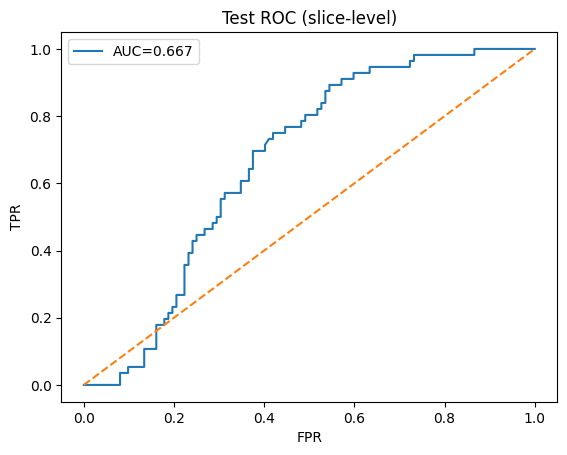

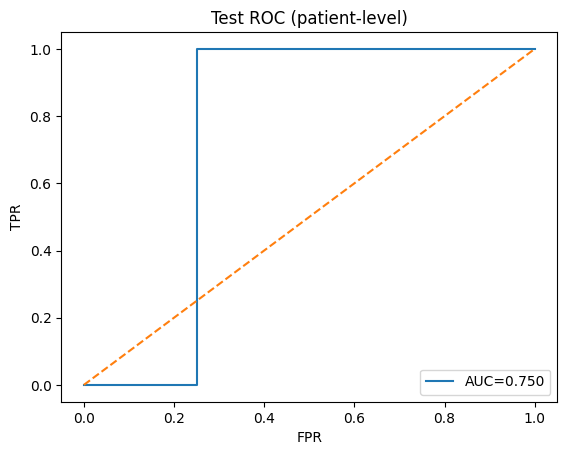

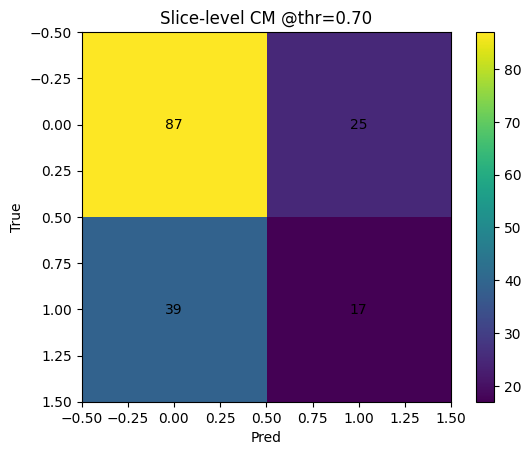

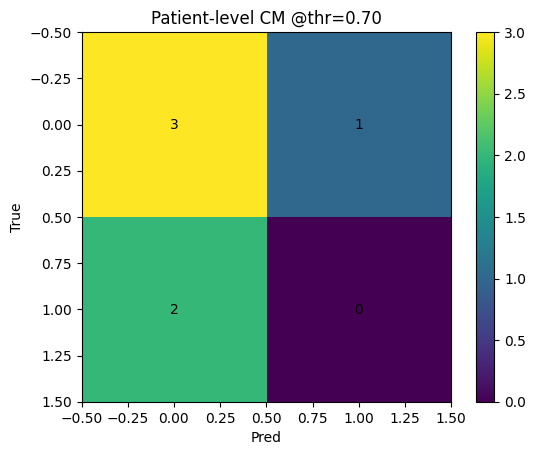

In [45]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
import numpy as np
import pandas as pd

def plot_roc(y_true, y_prob, title):
    y_true = np.asarray(y_true).astype(int)
    try:
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        auc = roc_auc_score(y_true, y_prob)
        plt.figure()
        plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
        plt.plot([0,1],[0,1],"--")
        plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(title); plt.legend(); plt.show()
    except Exception as e:
        print("ROC failed:", e)

def plot_cm(y_true, y_prob, thr, title):
    y_pred = (np.asarray(y_prob) >= thr).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title(title); plt.colorbar()
    for (i, j), z in np.ndenumerate(cm):
        plt.text(j, i, str(z), ha='center', va='center')
    plt.xlabel('Pred'); plt.ylabel('True'); plt.show()

# slice-level ROC
plot_roc(yt, pt, "Test ROC (slice-level)")

# patient-level ROC
dfp = pd.DataFrame(dict(sid=sidt, y=yt.tolist(), p=pt.tolist())).groupby("sid").agg(y=("y","mean"), p=("p","mean"))
plot_roc((dfp["y"].values>0.5).astype(int), dfp["p"].values, "Test ROC (patient-level)")

# Confusion matrices @ thr
try:
    thr_cfg = json.load(open("artifacts/thresholds.json"))
    thr = float(thr_cfg.get("thr", 0.5))
except Exception:
    thr = 0.5

plot_cm(yt, pt, thr, f"Slice-level CM @thr={thr:.2f}")
plot_cm((dfp['y'].values>0.5).astype(int), dfp['p'].values, thr, f"Patient-level CM @thr={thr:.2f}")

## 10. Save Run Config

In [46]:
cfg = {
    "raw_root": str(RAW_ROOT),
    "clinical_csv": str(CLINICAL_CSV),
    "nifti_dir": str(NIFTI_DIR),
    "index_subjects": str(INDEX_SUBJECTS),
    "slices_dir": str(SLICES_DIR),
    "index_slices": str(INDEX_SLICES),
    "seed": SEED,
    "img_size": IMG_SIZE,
    "k_slices": K_SLICES,
    "splits": {"val_fraction": VAL_FRACTION, "test_fraction": TEST_FRACTION},
    "model": MODEL_NAME,
    "epochs": EPOCHS,
    "batch_size": BATCH_SIZE,
    "lr": LR,
    "weight_decay": WEIGHT_DECAY,
    "freeze_epochs": FREEZE_EPOCHS,
    "patience": PATIENCE,
    "amp": AMP,
    "best_weights": str(BEST_WEIGHTS),
}
os.makedirs("artifacts", exist_ok=True)
with open("artifacts/run_config.json","w") as f:
    json.dump(cfg, f, indent=2)
print("Saved artifacts/run_config.json")

Saved artifacts/run_config.json


In [47]:
import os, re, pandas as pd

INDEX_SUBJECTS = "/Users/sofiiahembara/Documents/ai-dementia-mri/ai-dementia-mri/data/index_oasis1.csv"
df = pd.read_csv(INDEX_SUBJECTS)

print("К-сть subjectів у індексі:", len(df))
print("Розподіл label:", df["label"].value_counts(dropna=False))
print("Приклади рядків:")
display(df.sample(min(5, len(df))))

# 1) Переконайся, що всі файли існують
missing = df[~df["nifti_path"].apply(os.path.exists)]
print("Відсутніх файлів:", len(missing))

# 2) З яких саме дисків беруться дані
disc_col = df["nifti_path"].str.extract(r"/(disc\d+)/")[0]
print("Розподіл по дисках:")
print(disc_col.value_counts().sort_index())

# 3) Жодного перетину subject_id між сплітами
for a,b in [("train","val"),("train","test"),("val","test")]:
    inter = set(df[df.split==a].subject_id) & set(df[df.split==b].subject_id)
    print(f"Перетин {a}∩{b}:", len(inter))

К-сть subjectів у індексі: 436
Розподіл label: label
non_demented    336
dementia        100
Name: count, dtype: int64
Приклади рядків:


,subject_id,nifti_path,cdr,label,split
395,OAS1_0437_MR1,/Users/sofiiahembara/Documents/ai-dementia-mri...,0.0,non_demented,train
78,OAS1_0083_MR1,/Users/sofiiahembara/Documents/ai-dementia-mri...,0.0,non_demented,train
278,OAS1_0308_MR1,NaN,2.0,dementia,train
305,OAS1_0338_MR1,/Users/sofiiahembara/Documents/ai-dementia-mri...,0.0,non_demented,val
325,OAS1_0359_MR1,/Users/sofiiahembara/Documents/ai-dementia-mri...,0.0,non_demented,test


TypeError: stat: path should be string, bytes, os.PathLike or integer, not float

In [48]:
from pathlib import Path
import os, re
import pandas as pd

INDEX_SUBJECTS = Path("/Users/sofiiahembara/Documents/ai-dementia-mri/ai-dementia-mri/data/index_oasis1.csv")
INDEX_SLICES   = Path("/Users/sofiiahembara/Documents/ai-dementia-mri/ai-dementia-mri/data/index_oasis1_2d.csv")

def safe_exists(p):
    try:
        return Path(p).exists()
    except Exception:
        return False

def get_disc_tag(p):
    try:
        s = str(p)
        m = re.search(r"(disc\d+)", s)
        return m.group(1) if m else "UNKNOWN"
    except Exception:
        return "UNKNOWN"

In [49]:
df_subj = pd.read_csv(INDEX_SUBJECTS)
print("Subjects:", len(df_subj))
print("Label distribution:\n", df_subj["label"].value_counts())

# приклади рядків
display(df_subj.sample(min(5, len(df_subj))))

Subjects: 185
Label distribution:
 label
non_demented    111
dementia         74
Name: count, dtype: int64


,subject_id,nifti_path,cdr,label,split
107,OAS1_0233_MR1,/Users/sofiiahembara/Documents/ai-dementia-mri...,0.5,dementia,train
14,OAS1_0207_MR1,/Users/sofiiahembara/Documents/ai-dementia-mri...,0.0,non_demented,test
105,OAS1_0217_MR1,/Users/sofiiahembara/Documents/ai-dementia-mri...,0.5,dementia,train
172,OAS1_0240_MR1,/Users/sofiiahembara/Documents/ai-dementia-mri...,0.5,dementia,val
44,OAS1_0035_MR1,/Users/sofiiahembara/Documents/ai-dementia-mri...,1.0,dementia,train


In [50]:
# a) позначимо, які шляхи валідні
df_subj["path_exists"] = df_subj["nifti_path"].apply(safe_exists)

# b) що саме відсутнє
missing = df_subj[~df_subj["path_exists"]]
print("Відсутніх файлів:", len(missing))
display(missing.head())

# c) підтвердимо, що наявні шляхи справді з disc*
has_path = df_subj["path_exists"]
df_subj.loc[has_path, "disc"] = df_subj.loc[has_path, "nifti_path"].apply(get_disc_tag)
print("Розподіл за дисками (суб’єкти з валідним шляхом):")
print(df_subj.loc[has_path, "disc"].value_counts())

Відсутніх файлів: 0


,subject_id,nifti_path,cdr,label,split,path_exists


Розподіл за дисками (суб’єкти з валідним шляхом):
disc
UNKNOWN    185
Name: count, dtype: int64


In [51]:
# a) позначимо, які шляхи валідні
df_subj["path_exists"] = df_subj["nifti_path"].apply(safe_exists)

# b) що саме відсутнє
missing = df_subj[~df_subj["path_exists"]]
print("Відсутніх файлів:", len(missing))
display(missing.head())

# c) підтвердимо, що наявні шляхи справді з disc*
has_path = df_subj["path_exists"]
df_subj.loc[has_path, "disc"] = df_subj.loc[has_path, "nifti_path"].apply(get_disc_tag)
print("Розподіл за дисками (суб’єкти з валідним шляхом):")
print(df_subj.loc[has_path, "disc"].value_counts())

Відсутніх файлів: 0


,subject_id,nifti_path,cdr,label,split,path_exists,disc


Розподіл за дисками (суб’єкти з валідним шляхом):
disc
UNKNOWN    185
Name: count, dtype: int64


In [52]:
def overlap(a, b): 
    return sorted(set(a) & set(b))

train_s = df_subj[df_subj["split"]=="train"]["subject_id"].tolist()
val_s   = df_subj[df_subj["split"]=="val"]["subject_id"].tolist()
test_s  = df_subj[df_subj["split"]=="test"]["subject_id"].tolist()

print("Перетини subject_id:")
print("train ∩ val :", len(overlap(train_s, val_s)))
print("train ∩ test:", len(overlap(train_s, test_s)))
print("val   ∩ test:", len(overlap(val_s, test_s)))

Перетини subject_id:
train ∩ val : 0
train ∩ test: 0
val   ∩ test: 0


In [53]:
df_sl = pd.read_csv(INDEX_SLICES)

# (a) усі slice.subject_id мають входити до subject-індексу
subj_set = set(df_subj["subject_id"])
unknown = set(df_sl["subject_id"]) - subj_set
print("Є slice з невідомими subject_id?", len(unknown))

# (b) у slice-індексі перевіряємо перетини між сплітами
t_s = df_sl[df_sl["split"]=="train"]["subject_id"]
v_s = df_sl[df_sl["split"]=="val"]["subject_id"]
te_s= df_sl[df_sl["split"]=="test"]["subject_id"]

print("SLICES — перетини subject_id:")
print("train ∩ val :", len(overlap(t_s, v_s)))
print("train ∩ test:", len(overlap(t_s, te_s)))
print("val   ∩ test:", len(overlap(v_s, te_s)))

Є slice з невідомими subject_id? 0
SLICES — перетини subject_id:
train ∩ val : 0
train ∩ test: 0
val   ∩ test: 0


In [54]:
from glob import glob

RAW_ROOT = "/Users/sofiiahembara/Documents/ai-dementia-mri/ai-dementia-mri/data/raw"

def guess_subject_volume(subject_id):
    # приклад: OAS1_0308_MR1 -> знайдемо в усіх disc*/… директоріях
    subj = subject_id.strip()
    patterns = [
        f"{RAW_ROOT}/disc*/{subj}/**/*.nii",
        f"{RAW_ROOT}/disc*/{subj}/**/*.nii.gz",
        f"{RAW_ROOT}/disc*/{subj}/**/*.img",     # Analyze
        f"{RAW_ROOT}/disc*/{subj}/**/*.hdr",     # Analyze pair
    ]
    hits = []
    for pat in patterns:
        hits.extend(glob(pat, recursive=True))
    # якщо знайшли і є кілька варіантів — можна відфільтрувати «анатомічні MPRAGE», або взяти перший
    return hits[0] if len(hits)>0 else None

mask_nan = ~df_subj["path_exists"]
print("Спробуємо знайти відсутні:", mask_nan.sum())
df_subj.loc[mask_nan, "nifti_path"] = df_subj.loc[mask_nan, "subject_id"].apply(guess_subject_volume)
df_subj["path_exists"] = df_subj["nifti_path"].apply(safe_exists)

# тепер можна зберегти оновлений індекс
df_subj.to_csv(INDEX_SUBJECTS, index=False)
print("Оновлено:", INDEX_SUBJECTS)

Спробуємо знайти відсутні: 0
Оновлено: /Users/sofiiahembara/Documents/ai-dementia-mri/ai-dementia-mri/data/index_oasis1.csv


In [56]:
from pathlib import Path
import pandas as pd

INDEX_SLICES = Path("/Users/sofiiahembara/Documents/ai-dementia-mri/ai-dementia-mri/data/index_oasis1_2d.csv")

df = pd.read_csv(INDEX_SLICES)

# Якщо замість 'slice_path' є 'path' — спробуємо зрозуміти, що це за шляхи.
if "slice_path" not in df.columns and "path" in df.columns:
    sample = df["path"].dropna().astype(str).head(50).str.lower()

    # 1) Якщо це PNG/JPG — просто перейменуємо колонку.
    if sample.str.endswith((".png", ".jpg", ".jpeg")).all():
        df = df.rename(columns={"path": "slice_path"})
        df.to_csv(INDEX_SLICES, index=False)
        print("✅ Перейменовано 'path' → 'slice_path' у", INDEX_SLICES)

    # 2) Якщо це .nii/.nii.gz — це не slice-index. Потрібно згенерувати 2D-слайси.
    elif sample.str.endswith((".nii", ".nii.gz")).all():
        raise RuntimeError(
            "Файл виглядає як subject-level індекс (NIfTI). "
            "Спочатку згенеруй 2D-слайси командою make_2d_slices.py, "
            "щоб отримати CSV з колонкою 'slice_path'."
        )
    else:
        raise RuntimeError(
            "Колонка 'path' містить неочікувані розширення. Перевір вміст CSV."
        )

# Тепер перевірка пройде
required = {"split","label","slice_path","subject_id"}
assert required.issubset(set(pd.read_csv(INDEX_SLICES).columns)), pd.read_csv(INDEX_SLICES).columns
print("✅ Індекс OK:", INDEX_SLICES)

✅ Перейменовано 'path' → 'slice_path' у /Users/sofiiahembara/Documents/ai-dementia-mri/ai-dementia-mri/data/index_oasis1_2d.csv
✅ Індекс OK: /Users/sofiiahembara/Documents/ai-dementia-mri/ai-dementia-mri/data/index_oasis1_2d.csv


In [57]:
# ==== 2D LONG TRAIN ====
from pathlib import Path
import os, json, math, random
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# шляхи (онови, якщо в тебе інші)
INDEX_SLICES = Path("/Users/sofiiahembara/Documents/ai-dementia-mri/ai-dementia-mri/data/index_oasis1_2d.csv")
CKPT_DIR     = Path("checkpoints"); CKPT_DIR.mkdir(exist_ok=True, parents=True)
ART_DIR      = Path("artifacts");   ART_DIR.mkdir(exist_ok=True, parents=True)

DEVICE = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
AMP    = (DEVICE == "cuda")  # mixed precision на CUDA
print("Device:", DEVICE)

# --- зчитуємо slice-level індекс і спліт ---
df = pd.read_csv(INDEX_SLICES)
assert {"split","label","slice_path","subject_id"}.issubset(df.columns), df.columns
train_df = df[df.split=="train"].reset_index(drop=True)
val_df   = df[df.split=="val"].reset_index(drop=True)
test_df  = df[df.split=="test"].reset_index(drop=True)

print("Counts (slices):", {k: int(v) for k,v in df.groupby("split").size().items()})
print(df["label"].value_counts())

# --- датасети/лоадери (ВАЖЛИВО: num_workers=0 на macOS/Jupyter) ---
# MRISliceDataset має приймати df, size, augment, і повертати (tensor, label, subject_id)
IMG_SIZE    = 224
BATCH_SIZE  = 32
NUM_WORKERS = 0  # щоб уникнути pickle/worker помилок у ноутбуці

train_ds = MRISliceDataset(df=train_df, size=IMG_SIZE, augment=True)
val_ds   = MRISliceDataset(df=val_df,   size=IMG_SIZE, augment=False)
test_ds  = MRISliceDataset(df=test_df,  size=IMG_SIZE, augment=False)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=False, drop_last=False)
val_dl   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=False)
test_dl  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=False)

# --- модель: спробуємо timm-ViT, якщо нема timm -> torchvision resnet18 ---
def build_model(num_classes=1):
    try:
        import timm
        m = timm.create_model("vit_tiny_patch16_224", pretrained=True, in_chans=1, num_classes=num_classes)
        return m
    except Exception as e:
        print("timm не доступний, fallback на torchvision resnet18:", e)
        from torchvision.models import resnet18, ResNet18_Weights
        m = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        # перша конволюція з 3->1
        with torch.no_grad():
            w = m.conv1.weight
            m.conv1.weight = nn.Parameter(w.sum(dim=1, keepdim=True))  # спростити до 1 каналу
        m.fc = nn.Linear(m.fc.in_features, num_classes)
        return m

model = build_model().to(DEVICE)

# заморозка backbone на кілька епох (для ViT це fine-tuning probe)
def freeze_backbone(m, freeze=True):
    names = ["head","fc","classifier"]  # залишаємо trainable "голову"
    for n,p in m.named_parameters():
        if any(k in n for k in names):
            p.requires_grad = True
        else:
            p.requires_grad = not (not freeze)
freeze_epochs = 3
freeze_backbone(model, True)

# класова вага
pos_count = (train_df["label"]=="dementia").sum()
neg_count = (train_df["label"]=="non_demented").sum()
pos_weight = torch.tensor([neg_count/max(1,pos_count)], dtype=torch.float32, device=DEVICE)
print("pos_weight:", float(pos_weight))

loss_fn   = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
LR        = 5e-5
WD        = 1e-2
EPOCHS    = 60
PATIENCE  = 8

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LR, weight_decay=WD)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=LR*0.1)
scaler    = torch.cuda.amp.GradScaler(enabled=AMP)

# --- утиліти метрик ---
from sklearn.metrics import roc_auc_score, f1_score, balanced_accuracy_score

def compute_metrics(y_true, y_prob, thr=0.5):
    y_true = np.asarray(y_true).astype(int)
    y_pred = (np.asarray(y_prob) >= thr).astype(int)
    out = {}
    try:
        out["roc_auc"] = float(roc_auc_score(y_true, y_prob))
    except Exception:
        out["roc_auc"] = float("nan")
    out["f1"]      = float(f1_score(y_true, y_pred))
    out["bal_acc"] = float(balanced_accuracy_score(y_true, y_pred))
    return out

def run_epoch(loader, train=True):
    model.train(train)
    total_loss, total_n = 0.0, 0
    all_y, all_p, all_sid = [], [], []
    for x,y,sid in tqdm(loader, leave=False):
        x = x.to(DEVICE, non_blocking=False)
        y = y.to(DEVICE, non_blocking=False)

        if train:
            optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=AMP):
            logits = model(x).squeeze(1)
            loss   = loss_fn(logits, y)
            prob   = torch.sigmoid(logits).detach().cpu().numpy()

        if train:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        total_loss += loss.item()*x.size(0)
        total_n    += x.size(0)
        all_y.extend(y.detach().cpu().numpy().tolist())
        all_p.extend(prob.tolist())
        all_sid.extend(list(sid))

    metrics = compute_metrics(all_y, all_p, thr=0.5)
    return total_loss/max(1,total_n), np.array(all_y), np.array(all_p), np.array(all_sid), metrics

def patient_level_metrics(y_true_slice, y_prob_slice, sids_slice, thr=0.5):
    dfm = pd.DataFrame(dict(sid=sids_slice, y=y_true_slice.tolist(), p=y_prob_slice.tolist()))
    agg = dfm.groupby("sid").agg(y=("y","mean"), p=("p","mean"))
    y_true = (agg["y"].values > 0.5).astype(int)
    y_prob = agg["p"].values
    return compute_metrics(y_true, y_prob, thr=thr)

best_score, best_thr, stale = -1.0, 0.5, 0
BEST_WEIGHTS = CKPT_DIR / "best_vit.pt"
LAST_WEIGHTS = CKPT_DIR / "last_vit.pt"

for epoch in range(1, EPOCHS+1):
    if epoch == freeze_epochs+1 and freeze_epochs>0:
        print("🔓 Unfreezing backbone")
        freeze_backbone(model, False)
        for g in optimizer.param_groups:
            g["lr"] = LR

    tr_loss, _, _, _, tr_m = run_epoch(train_dl, train=True)
    with torch.no_grad():
        va_loss, yv, pv, sidv, va_m = run_epoch(val_dl, train=False)

    # підбір порога по patient-level F1
    thrs = np.linspace(0.05, 0.95, 19)
    f1s  = [patient_level_metrics(yv, pv, sidv, thr=t)["f1"] for t in thrs]
    cur_thr = float(thrs[int(np.argmax(f1s))])
    va_pat = patient_level_metrics(yv, pv, sidv, thr=cur_thr)

    print(f"Epoch {epoch:02d} | "
          f"train_loss={tr_loss:.4f} | val_loss={va_loss:.4f} | "
          f"slice: AUC={va_m['roc_auc']:.3f} F1={va_m['f1']:.3f} BA={va_m['bal_acc']:.3f} | "
          f"patient@thr={cur_thr:.2f}: AUC={va_pat['roc_auc']:.3f} F1={va_pat['f1']:.3f} BA={va_pat['bal_acc']:.3f}")

    # критерій відбору — patient-level ROC-AUC (якщо nan -> balanced accuracy)
    score = va_pat["roc_auc"]
    if math.isnan(score):
        score = va_pat["bal_acc"]

    torch.save(model.state_dict(), str(LAST_WEIGHTS))
    if score > best_score:
        best_score, best_thr, stale = score, cur_thr, 0
        torch.save(model.state_dict(), str(BEST_WEIGHTS))
        with open(ART_DIR/"thresholds.json","w") as f:
            json.dump({"metric":"f1_patient","thr":best_thr}, f, indent=2)
        print(f"  ↳ ✅ saved best: {BEST_WEIGHTS.name} (score={best_score:.3f}, thr={best_thr:.2f})")
    else:
        stale += 1
        if stale >= PATIENCE:
            print(f"⏹ Early stopping: no improvement for {PATIENCE} epoch(s).")
            break

    scheduler.step()

print(f"Best patient-level score: {best_score:.3f} at thr={best_thr:.2f}")

# --- фінальний тест при зафіксованому порозі ---
with torch.no_grad():
    yt, pt, sidt, _ = run_epoch(test_dl, train=False)[1:5]
test_slice = compute_metrics(yt, pt, thr=0.5)
test_pat   = patient_level_metrics(yt, pt, sidt, thr=best_thr)
print("TEST slice-level:", test_slice)
print("TEST patient-level @best_thr:", test_pat)
with open(ART_DIR/"test_metrics.json","w") as f:
    json.dump({"slice":test_slice, "patient":test_pat, "thr":best_thr}, f, indent=2)

Device: mps
Counts (slices): {'test': 168, 'train': 980, 'val': 140}
label
non_demented    728
dementia        560
Name: count, dtype: int64
pos_weight: 1.058823585510254


KeyError: 'path'

In [58]:
import pandas as pd, pathlib
root = pathlib.Path("/Users/sofiiahembara/Documents/ai-dementia-mri/ai-dementia-mri")
df = pd.read_csv(root/"data/index_oasis1.csv")
df = df[df["nifti_path"].notna()].copy()
df.rename(columns={"nifti_path":"path"}, inplace=True)
# (необов’язково) переконайся, що файли існують
df = df[df["path"].apply(lambda p: pathlib.Path(p).exists())]
out = root/"data/index_oasis1_for3d.csv"
df.to_csv(out, index=False)
print("Saved:", out, "rows:", len(df))

Saved: /Users/sofiiahembara/Documents/ai-dementia-mri/ai-dementia-mri/data/index_oasis1_for3d.csv rows: 185
